In [26]:
import numpy as np
import pymc3 as pm

import pickle
from datetime import datetime

import seaborn as sns
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor

from epimodel.pymc3_models.cm_effect.models.base_model import add_cms_to_plot
sns.set_style("ticks")
%matplotlib inline

In [5]:
dp = DataPreprocessor(drop_HS=True)
data = dp.preprocess_data("./double-entry-data/double_entry_alt_masks.csv", last_day="2020-05-30", schools_unis="single_features")

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Screen/Quarantine
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Bans
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Transport Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Internal Movement Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Information Campaigns
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Symptomatic Testing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Georgia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
IN

In [8]:
folds = [['FR', 'GR', 'NL', 'BA', 'LV'],
         ['SE', 'DE', 'LT', 'MY', 'BG'],
         ['FI', 'DK', 'CZ', 'RS', 'BE'],
         ['NO', 'SK', 'IL', 'CH', 'ES'],
         ['ZA', 'MX', 'IT', 'IE', 'GE'],
         ['RO', 'PL', 'MA', 'HU', 'SI'],
         ['NZ', 'SG', 'PT', 'HR', 'EE']]

In [22]:
def month_to_str(x):
    if x == 1:
        return "JAN"
    if x == 2:
        return "FEB"
    if x == 3:
        return "MAR"
    if x == 4:
        return "APR"
    if x == 5:
        return "MAY"
    
cm_plot_style = [
#             ("\uf7f2", "tab:red"), # hospital symbol
            ("\uf963", "black"), # mask
            ("\uf0c0", "darkgrey"), # ppl
            ("\uf0c0", "dimgrey"), # ppl
            ("\uf0c0", "black"), # ppl
            ("\uf07a", "tab:orange"), # shop 1
            ("\uf07a", "tab:red"), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black") # home
]


In [16]:
def produce_CIs(data):
    means = np.median(data, axis=0)
    li = np.percentile(data, 2.5, axis=0)
    ui = np.percentile(data, 97.5, axis=0)
    err = np.array([means - li, ui - means])
    return means, li, ui, err

In [8]:
class ResultsObject():
    def __init__(self, indxs, trace):
        self.CMReduction = trace.CMReduction
        self.RegionLogR = trace.RegionLogR[:, indxs]
        self.InfectedCases = trace.InfectedCases[:, indxs, :]
        self.InfectedDeaths = trace.InfectedDeaths[:, indxs, :]
        self.ExpectedCases = trace.ExpectedCases[:, indxs, :]
        self.ExpectedDeaths = trace.ExpectedDeaths[:, indxs, :]
        self.Phi = trace.Phi_1
        
def mask_region(d, region, days=14):
    i = d.Rs.index(region)
    c_s = np.nonzero(np.cumsum(d.NewCases.data[i, :] > 0) == days + 1)[0][0]
    d_s = np.nonzero(np.cumsum(d.NewDeaths.data[i, :] > 0) == days + 1)[0]
    if len(d_s) > 0:
        d_s = d_s[0]
    else:
        d_s = len(d.Ds)

    d.Active.mask[i, c_s:] = True
    d.Confirmed.mask[i, c_s:] = True
    d.Deaths.mask[i, d_s:] = True
    d.NewDeaths.mask[i, d_s:] = True
    d.NewCases.mask[i, c_s:] = True

    return c_s, d_s

<Figure size 3000x4200 with 0 Axes>

<Figure size 3000x4200 with 0 Axes>

In [21]:
data = dp.preprocess_data("./double-entry-data/double_entry_final.csv", last_day="2020-05-30",
                                  schools_unis="whoops")
data.mask_reopenings()

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Screen/Quarantine
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Bans
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Transport Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Internal Movement Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Information Campaigns
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Symptomatic Testing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Georgia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
IN

Masking AL from 2020-04-30 00:00:00+00:00
Masking AD from 2020-05-21 00:00:00+00:00
Masking AT from 2020-05-04 00:00:00+00:00
Masking AT from 2020-05-21 00:00:00+00:00
Masking BE from 2020-05-14 00:00:00+00:00
Masking BA from 2020-05-17 00:00:00+00:00
Masking BG from 2020-05-04 00:00:00+00:00
Masking BG from 2020-05-21 00:00:00+00:00
Masking HR from 2020-04-30 00:00:00+00:00
Masking HR from 2020-05-14 00:00:00+00:00
Masking HR from 2020-05-29 00:00:00+00:00
Masking CZ from 2020-04-27 00:00:00+00:00
Masking CZ from 2020-05-14 00:00:00+00:00
Masking CZ from 2020-05-28 00:00:00+00:00
Masking DK from 2020-04-23 00:00:00+00:00
Masking DK from 2020-05-14 00:00:00+00:00
Masking FI from 2020-05-17 00:00:00+00:00
Masking FR from 2020-05-14 00:00:00+00:00
Masking GE from 2020-05-26 00:00:00+00:00
Masking GE from 2020-05-27 00:00:00+00:00
Masking DE from 2020-04-23 00:00:00+00:00
Masking DE from 2020-05-07 00:00:00+00:00
Masking DE from 2020-05-09 00:00:00+00:00
Masking GR from 2020-05-07 00:00:0

In [71]:
def compute_metric(fold, growth_noise, alpha_noise):
    file = f'../server/diffeff/diffeff_crossval/{alpha_noise}-{growth_noise}-f{fold}.pkl'
    res = pickle.load(open(file, 'rb'))
    
    r_is = [data.Rs.index(r) for r in folds[fold]]
    nd_cases = 0
    nd_deaths = 0
    
    nS, _, _ = res.ExpectedDeaths.shape
    
    cases_ll = 0
    deaths_ll = 0
    
    for i, (rg, r_i) in enumerate(zip(folds[fold], r_is)):
        cases_start, deaths_start = mask_region(data, rg)
        total_cms = data.ActiveCMs[r_i, :, :]
        diff_cms = np.zeros_like(total_cms)
        diff_cms[:, 1:] = total_cms[:, 1:] - total_cms[:, :-1]
        ds = np.nonzero(np.any(diff_cms < 0, axis=0))
        if len(ds[0]) > 0:
            cases_end = ds[0][0]+3
            deaths_end = ds[0][0]+12
        else:
            cases_end = len(data.Ds)-1
            deaths_end = cases_end
        
        nd_cases_rg = cases_end - cases_start + 1
        nd_deaths_rg = deaths_end - deaths_start + 1
        
        nd_cases += nd_cases_rg
        
        # now actually compute likelihoods
        if nd_deaths_rg > 5:
            nd_deaths += nd_deaths_rg
            expected_deaths = res.ExpectedDeaths[:, i, deaths_start:(deaths_end+1)]
            death_dist = pm.NegativeBinomial.dist(mu=expected_deaths, alpha=np.repeat(res.Phi.reshape((nS, 1)), nd_deaths_rg, axis=1))     
            deaths_ll += np.sum(np.log(np.mean(np.exp(death_dist.logp(data.NewDeaths.data[r_i, deaths_start:(deaths_end+1)].reshape((1, nd_deaths_rg))).eval()))))
        
        expected_cases = res.ExpectedDeaths[:, i, cases_start:(cases_end+1)]
        cases_dist = pm.NegativeBinomial.dist(mu=expected_cases, alpha=np.repeat(res.Phi.reshape((nS, 1)), nd_cases_rg, axis=1))     
        cases_ll += np.sum(np.log(np.mean(np.exp(cases_dist.logp(data.NewCases.data[r_i, cases_start:(cases_end+1)].reshape((1, nd_cases_rg))).eval()))))
        
    return ((cases_ll, nd_cases, cases_ll/nd_cases), (deaths_ll, nd_deaths, deaths_ll/nd_deaths))

def aggregate_metric(growth_noise, alpha_noise):
    nd_cases = 0
    nd_deaths = 0
    cases_ll = 0
    deaths_ll = 0
    
    for fold in range(len(folds)):
        cases_res, deaths_res = compute_metric(fold, growth_noise, alpha_noise)
        
        nd_cases += cases_res[1]
        cases_ll += cases_res[0]
        nd_deaths += deaths_res[1]
        deaths_ll += deaths_res[0]
    
    return cases_ll/nd_cases, deaths_ll/nd_deaths

In [76]:
alpha_noise = [0.05, 0.075, 0.1, 0.125, 0.15]
growth_noise = [0.05, 0.1, 0.15, 0.175, 0.2, 0.225, 0.25]

cases_grid = np.zeros((len(alpha_noise), len(growth_noise)))
deaths_grid = np.zeros((len(alpha_noise), len(growth_noise)))

for a_i, alpha in enumerate(alpha_noise):
    for g_i, gnoise in enumerate(growth_noise):
        res = aggregate_metric(gnoise, alpha)
        cases_grid[a_i, g_i] = res[0]
        deaths_grid[a_i, g_i] = res[1]
        print(f'({alpha}, {gnoise}) cases {res[0]:.3f} deaths {res[1]:.3f}')

(0.05, 0.05) cases -0.358 deaths -0.095
(0.05, 0.1) cases -0.337 deaths -0.089
(0.05, 0.15) cases -0.300 deaths -0.085
(0.05, 0.175) cases -0.284 deaths -0.084
(0.05, 0.2) cases -0.266 deaths -0.084
(0.05, 0.225) cases -0.263 deaths -0.083
(0.05, 0.25) cases -0.260 deaths -0.083
(0.075, 0.05) cases -0.353 deaths -0.095
(0.075, 0.1) cases -0.322 deaths -0.090
(0.075, 0.15) cases -0.293 deaths -0.086
(0.075, 0.175) cases -0.277 deaths -0.085
(0.075, 0.2) cases -0.247 deaths -0.084
(0.075, 0.225) cases -0.227 deaths -0.083
(0.075, 0.25) cases -0.230 deaths -0.083
(0.1, 0.05) cases -0.342 deaths -0.094
(0.1, 0.1) cases -0.300 deaths -0.090
(0.1, 0.15) cases -0.278 deaths -0.086
(0.1, 0.175) cases -0.263 deaths -0.085
(0.1, 0.2) cases -0.245 deaths -0.085
(0.1, 0.225) cases -0.220 deaths -0.084
(0.1, 0.25) cases -0.221 deaths -0.084
(0.125, 0.05) cases -0.328 deaths -0.094
(0.125, 0.1) cases -0.287 deaths -0.090
(0.125, 0.15) cases -0.263 deaths -0.087
(0.125, 0.175) cases -0.252 deaths -0.

# some plots

In [38]:
folds = [['FR', 'GR', 'NL', 'BA', 'LV'],
         ['SE', 'DE', 'LT', 'MY', 'BG'],
         ['FI', 'DK', 'CZ', 'RS', 'BE'],
         ['NO', 'SK', 'IL', 'CH', 'ES'],
         ['ZA', 'MX', 'IT', 'IE', 'GE'],
         ['RO', 'PL', 'MA', 'HU', 'SI'],
         ['NZ', 'SG', 'PT', 'HR', 'EE']]

In [42]:
alpha = 0.15
g = 0.05

In [43]:
data = dp.preprocess_data("./double-entry-data/double_entry_final.csv", last_day="2020-05-30",
                                  schools_unis="whoops")
data.mask_reopenings()

start_d_i = 30

plt.figure(figsize=(15, 15), dpi=300)

for row, fold in enumerate(folds[:5]):
    file = f'../server/diffeff/diffeff_crossval/{alpha}-{g}-f{row}.pkl'
    res = pickle.load(open(file, 'rb'))
    for col, region in enumerate(fold):
        r_i = data.Rs.index(region)
        p_i = row * 5 + col + 1
        
        plt.subplot(5, 5, p_i)
        ax = plt.gca()

        if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
            end_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]-3
        else:
            end_d_i = len(data.Ds)
            
        mask_region(data, region)

        means_d, lu_id, up_id, err_d = produce_CIs(
                    res.InfectedDeaths[:, col]
                )

        means_c, lu_ic, up_ic, err_c = produce_CIs(
                    res.InfectedCases[:, col]
                )

        ec = res.ExpectedDeaths[:, col, :]
        nS, nDs = ec.shape

        try:
            dist = pm.NegativeBinomial.dist(mu=ec, alpha=60)
            ec_output = dist.random()
        except ValueError:
            ec_output = 0 * ec
            means_d = means_d * 0
            lu_id = lu_id * 0
            up_id = up_id * 0

        means_expected_deaths, lu_ed, up_ed, err_expected_deaths = produce_CIs(
            ec_output
        )

        eco = res.ExpectedCases[:, col, :]
        nS, nDs = eco.shape

        try:
            dist = pm.NegativeBinomial.dist(mu=eco, alpha=60)
            eco_output = dist.random()
        except ValueError:
            eco_output = 10**-10 * ec

        means_expected_cases, lu_ec, up_ec, err_expected_cases = produce_CIs(
            eco_output
        )


        days = data.Ds
        days_x = np.arange(len(days))
        deaths = data.NewDeaths[r_i, :]
        cases = data.NewCases[r_i, :]

        ax = plt.gca()
        plt.plot(
            days_x,
            means_d,
            label="Daily Infections - Later Fatal",
            zorder=1,
            color="tab:orange",
            alpha=0.25
        )

        plt.fill_between(
            days_x, lu_id, up_id, alpha=0.15, color="tab:orange", linewidth=0
        )

        plt.plot(
            days_x,
            means_expected_deaths,
            label="Predicted Daily Deaths",
            zorder=2,
            color="tab:red"
        )

        plt.fill_between(
            days_x, lu_ed, up_ed, alpha=0.25, color="tab:red", linewidth=0
        )

        plt.scatter(
            days_x,
            deaths,
            label="Recorded Daily Deaths (Smoothed)",
            marker="o",
            s=10,
            color="tab:red",
            alpha=0.9,
            zorder=3,
        )

        plt.scatter(
            days_x,
            deaths.data,
            label="Heldout Daily Deaths (Cases)",
            marker="o",
            s=12,
            edgecolor="tab:red",
            facecolor="white",
            linewidth=1,
            alpha=0.9,
            zorder=2,
        )

        plt.plot(
            days_x,
            means_c,
            label="Daily Infections - Later Reported",
            zorder=1,
            color="tab:purple",
            alpha=0.25
        )

        plt.fill_between(
            days_x, lu_ic, up_ic, alpha=0.15, color="tab:purple", linewidth=0
        )

        plt.plot(
            days_x,
            means_expected_cases,
            label="Predicted Daily Confirmed Cases",
            zorder=2,
            color="tab:blue"
        )

        plt.fill_between(
            days_x, lu_ec, up_ec, alpha=0.25, color="tab:blue", linewidth=0
        )

        plt.scatter(
            days_x,
            cases,
            label="Recorded Daily Confirmed Cases (Smoothed)",
            marker="o",
            s=10,
            color="tab:blue",
            alpha=0.9,
            zorder=3,
        )

        plt.scatter(
            days_x,
            cases.data,
            label="Heldout Daily Confirmed Cases (Cases)",
            marker="o",
            s=12,
            edgecolor="tab:blue",
            facecolor="white",
            linewidth=1,
            alpha=0.9,
            zorder=2,
        )

        ax.set_yscale("log")
        plt.ylim([10 ** 0, 10 ** 6])
        locs = np.arange(start_d_i, end_d_i, 14)
        xlabels = [f"{data.Ds[ts].day}-{month_to_str(data.Ds[ts].month)}" for ts in locs]
        plt.xticks(locs, xlabels, rotation=-30, ha="left")
        plt.xlim((start_d_i, end_d_i))
        plt.title(f'Phi: {np.mean(res.Phi):.1f}, {data.RNames[region][0]}')
#         add_cms_to_plot(ax, data.ActiveCMs, r_i, start_d_i, end_d_i, data.Ds, cm_plot_style)

plt.tight_layout()
ax.legend(shadow=True, fancybox=True, loc = "upper center", bbox_to_anchor = (-2.85, -0.25), fontsize=8, ncol=4)
plt.savefig(f"DiffEff{alpha}-{g}.pdf", bbox_inches='tight')

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Screen/Quarantine
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Bans
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Transport Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Internal Movement Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Information Campaigns
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Symptomatic Testing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Georgia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
IN

Masking AL from 2020-04-30 00:00:00+00:00
Masking AD from 2020-05-21 00:00:00+00:00
Masking AT from 2020-05-04 00:00:00+00:00
Masking AT from 2020-05-21 00:00:00+00:00
Masking BE from 2020-05-14 00:00:00+00:00
Masking BA from 2020-05-17 00:00:00+00:00
Masking BG from 2020-05-04 00:00:00+00:00
Masking BG from 2020-05-21 00:00:00+00:00
Masking HR from 2020-04-30 00:00:00+00:00
Masking HR from 2020-05-14 00:00:00+00:00
Masking HR from 2020-05-29 00:00:00+00:00
Masking CZ from 2020-04-27 00:00:00+00:00
Masking CZ from 2020-05-14 00:00:00+00:00
Masking CZ from 2020-05-28 00:00:00+00:00
Masking DK from 2020-04-23 00:00:00+00:00
Masking DK from 2020-05-14 00:00:00+00:00
Masking FI from 2020-05-17 00:00:00+00:00
Masking FR from 2020-05-14 00:00:00+00:00
Masking GE from 2020-05-26 00:00:00+00:00
Masking GE from 2020-05-27 00:00:00+00:00
Masking DE from 2020-04-23 00:00:00+00:00
Masking DE from 2020-05-07 00:00:00+00:00
Masking DE from 2020-05-09 00:00:00+00:00
Masking GR from 2020-05-07 00:00:0

NameError: name 'f' is not defined

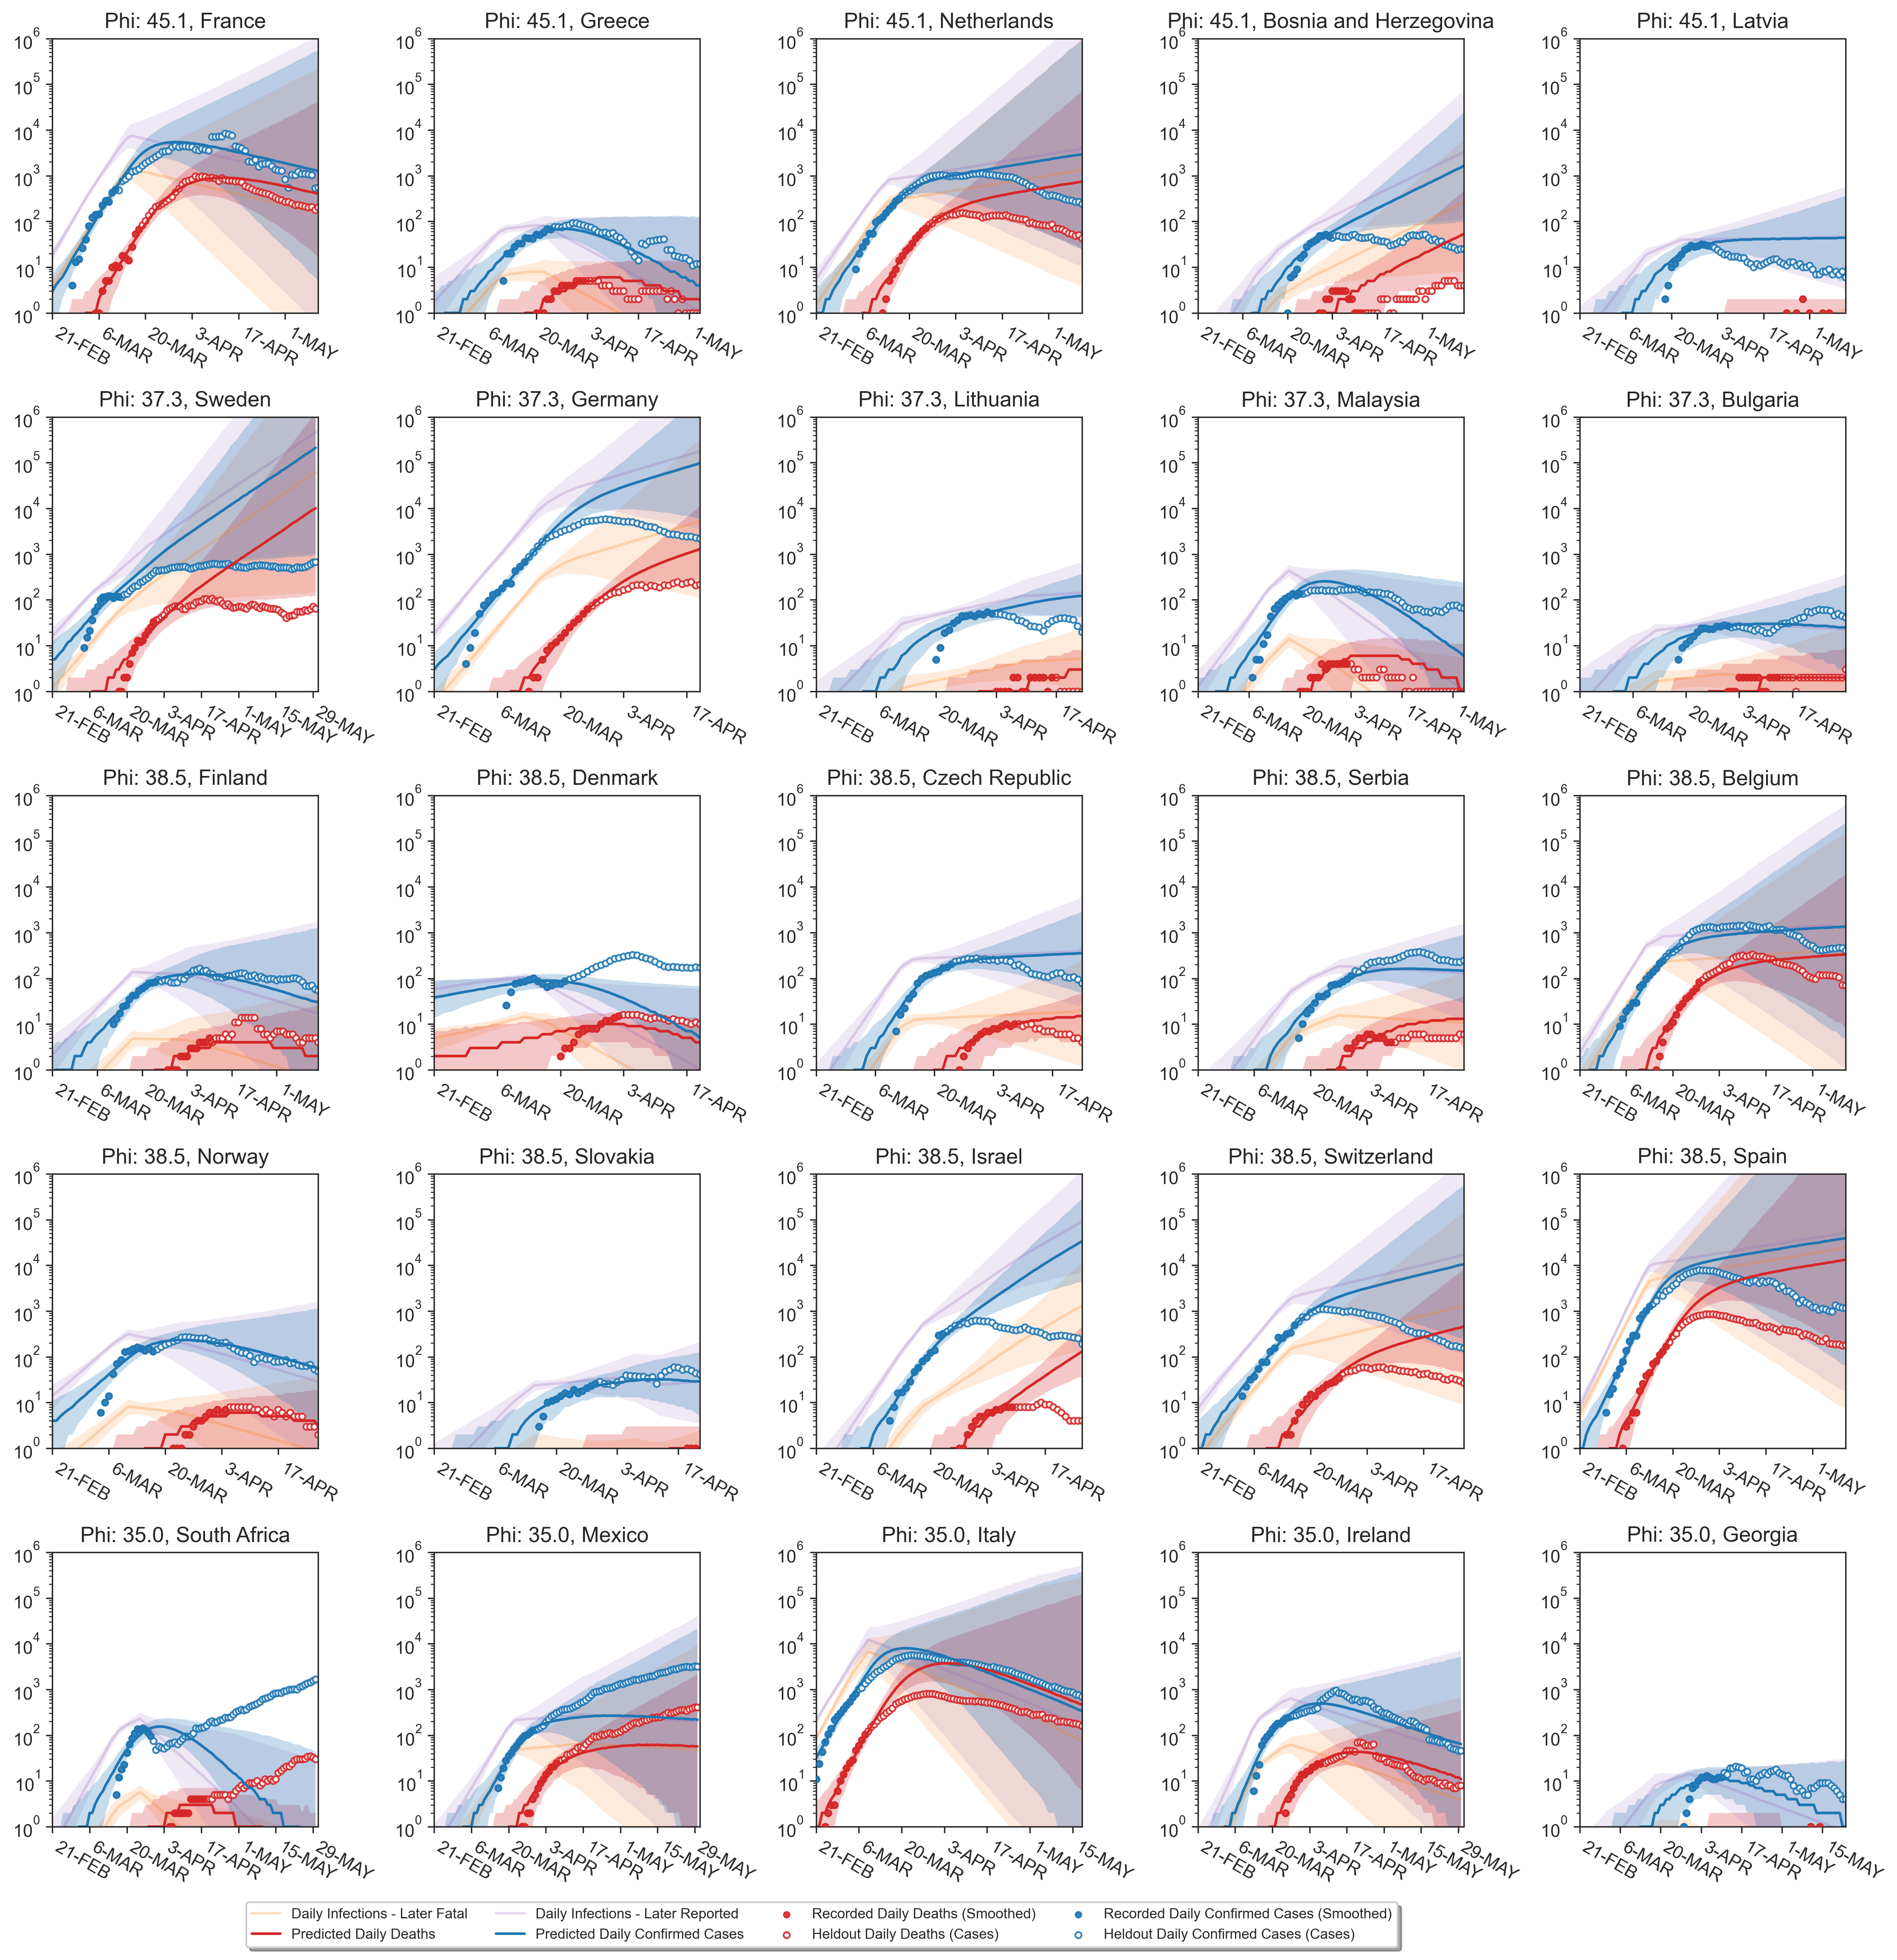

In [44]:
f

In [50]:
file = f'../server/diffeff/diffeff_crossval/0.15-0.25-f0.pkl'
res = pickle.load(open(file, 'rb'))

In [51]:
np.mean(res.CMReduction, axis=0)

array([0.89246357, 0.99886438, 0.83227793, 0.81384168, 0.69333881,
       0.87784014, 0.90153983, 0.76213885, 0.75494657])

In [52]:
alphas = [0.05, 0.075, 0.1, 0.125, 0.15]
g = 0.05

In [53]:
for alpha in alphas:
    data = dp.preprocess_data("./double-entry-data/double_entry_final.csv", last_day="2020-05-30",
                                  schools_unis="whoops")
    data.mask_reopenings()

    start_d_i = 30

    plt.figure(figsize=(15, 15), dpi=300)

    for row, fold in enumerate(folds[:5]):
        file = f'../server/diffeff/diffeff_crossval/{alpha}-{g}-f{row}.pkl'
        res = pickle.load(open(file, 'rb'))
        for col, region in enumerate(fold):
            r_i = data.Rs.index(region)
            p_i = row * 5 + col + 1

            plt.subplot(5, 5, p_i)
            ax = plt.gca()

            if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
                end_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]-3
            else:
                end_d_i = len(data.Ds)

            mask_region(data, region)

            means_d, lu_id, up_id, err_d = produce_CIs(
                        res.InfectedDeaths[:, col]
                    )

            means_c, lu_ic, up_ic, err_c = produce_CIs(
                        res.InfectedCases[:, col]
                    )

            ec = res.ExpectedDeaths[:, col, :]
            nS, nDs = ec.shape

            try:
                dist = pm.NegativeBinomial.dist(mu=ec, alpha=60)
                ec_output = dist.random()
            except ValueError:
                ec_output = 0 * ec
                means_d = means_d * 0
                lu_id = lu_id * 0
                up_id = up_id * 0

            means_expected_deaths, lu_ed, up_ed, err_expected_deaths = produce_CIs(
                ec_output
            )

            eco = res.ExpectedCases[:, col, :]
            nS, nDs = eco.shape

            try:
                dist = pm.NegativeBinomial.dist(mu=eco, alpha=60)
                eco_output = dist.random()
            except ValueError:
                eco_output = 10**-10 * ec

            means_expected_cases, lu_ec, up_ec, err_expected_cases = produce_CIs(
                eco_output
            )


            days = data.Ds
            days_x = np.arange(len(days))
            deaths = data.NewDeaths[r_i, :]
            cases = data.NewCases[r_i, :]

            ax = plt.gca()
            plt.plot(
                days_x,
                means_d,
                label="Daily Infections - Later Fatal",
                zorder=1,
                color="tab:orange",
                alpha=0.25
            )

            plt.fill_between(
                days_x, lu_id, up_id, alpha=0.15, color="tab:orange", linewidth=0
            )

            plt.plot(
                days_x,
                means_expected_deaths,
                label="Predicted Daily Deaths",
                zorder=2,
                color="tab:red"
            )

            plt.fill_between(
                days_x, lu_ed, up_ed, alpha=0.25, color="tab:red", linewidth=0
            )

            plt.scatter(
                days_x,
                deaths,
                label="Recorded Daily Deaths (Smoothed)",
                marker="o",
                s=10,
                color="tab:red",
                alpha=0.9,
                zorder=3,
            )

            plt.scatter(
                days_x,
                deaths.data,
                label="Heldout Daily Deaths (Cases)",
                marker="o",
                s=12,
                edgecolor="tab:red",
                facecolor="white",
                linewidth=1,
                alpha=0.9,
                zorder=2,
            )

            plt.plot(
                days_x,
                means_c,
                label="Daily Infections - Later Reported",
                zorder=1,
                color="tab:purple",
                alpha=0.25
            )

            plt.fill_between(
                days_x, lu_ic, up_ic, alpha=0.15, color="tab:purple", linewidth=0
            )

            plt.plot(
                days_x,
                means_expected_cases,
                label="Predicted Daily Confirmed Cases",
                zorder=2,
                color="tab:blue"
            )

            plt.fill_between(
                days_x, lu_ec, up_ec, alpha=0.25, color="tab:blue", linewidth=0
            )

            plt.scatter(
                days_x,
                cases,
                label="Recorded Daily Confirmed Cases (Smoothed)",
                marker="o",
                s=10,
                color="tab:blue",
                alpha=0.9,
                zorder=3,
            )

            plt.scatter(
                days_x,
                cases.data,
                label="Heldout Daily Confirmed Cases (Cases)",
                marker="o",
                s=12,
                edgecolor="tab:blue",
                facecolor="white",
                linewidth=1,
                alpha=0.9,
                zorder=2,
            )

            ax.set_yscale("log")
            plt.ylim([10 ** 0, 10 ** 6])
            locs = np.arange(start_d_i, end_d_i, 14)
            xlabels = [f"{data.Ds[ts].day}-{month_to_str(data.Ds[ts].month)}" for ts in locs]
            plt.xticks(locs, xlabels, rotation=-30, ha="left")
            plt.xlim((start_d_i, end_d_i))
            plt.title(f'Phi: {np.mean(res.Phi):.1f}, {data.RNames[region][0]}')
    #         add_cms_to_plot(ax, data.ActiveCMs, r_i, start_d_i, end_d_i, data.Ds, cm_plot_style)

    plt.tight_layout()
    ax.legend(shadow=True, fancybox=True, loc = "upper center", bbox_to_anchor = (-2.85, -0.25), fontsize=8, ncol=4)
    plt.savefig(f"DiffEff{alpha}-{g}.pdf", bbox_inches='tight')

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Screen/Quarantine
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Bans
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Transport Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Internal Movement Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Information Campaigns
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Symptomatic Testing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Georgia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
IN

Masking AL from 2020-04-30 00:00:00+00:00
Masking AD from 2020-05-21 00:00:00+00:00
Masking AT from 2020-05-04 00:00:00+00:00
Masking AT from 2020-05-21 00:00:00+00:00
Masking BE from 2020-05-14 00:00:00+00:00
Masking BA from 2020-05-17 00:00:00+00:00
Masking BG from 2020-05-04 00:00:00+00:00
Masking BG from 2020-05-21 00:00:00+00:00
Masking HR from 2020-04-30 00:00:00+00:00
Masking HR from 2020-05-14 00:00:00+00:00
Masking HR from 2020-05-29 00:00:00+00:00
Masking CZ from 2020-04-27 00:00:00+00:00
Masking CZ from 2020-05-14 00:00:00+00:00
Masking CZ from 2020-05-28 00:00:00+00:00
Masking DK from 2020-04-23 00:00:00+00:00
Masking DK from 2020-05-14 00:00:00+00:00
Masking FI from 2020-05-17 00:00:00+00:00
Masking FR from 2020-05-14 00:00:00+00:00
Masking GE from 2020-05-26 00:00:00+00:00
Masking GE from 2020-05-27 00:00:00+00:00
Masking DE from 2020-04-23 00:00:00+00:00
Masking DE from 2020-05-07 00:00:00+00:00
Masking DE from 2020-05-09 00:00:00+00:00
Masking GR from 2020-05-07 00:00:0

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Screen/Quarantine
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Bans
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Transport Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Internal Movement Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Information Campaigns
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Symptomatic Testing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Georgia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
IN

Masking AL from 2020-04-30 00:00:00+00:00
Masking AD from 2020-05-21 00:00:00+00:00
Masking AT from 2020-05-04 00:00:00+00:00
Masking AT from 2020-05-21 00:00:00+00:00
Masking BE from 2020-05-14 00:00:00+00:00
Masking BA from 2020-05-17 00:00:00+00:00
Masking BG from 2020-05-04 00:00:00+00:00
Masking BG from 2020-05-21 00:00:00+00:00
Masking HR from 2020-04-30 00:00:00+00:00
Masking HR from 2020-05-14 00:00:00+00:00
Masking HR from 2020-05-29 00:00:00+00:00
Masking CZ from 2020-04-27 00:00:00+00:00
Masking CZ from 2020-05-14 00:00:00+00:00
Masking CZ from 2020-05-28 00:00:00+00:00
Masking DK from 2020-04-23 00:00:00+00:00
Masking DK from 2020-05-14 00:00:00+00:00
Masking FI from 2020-05-17 00:00:00+00:00
Masking FR from 2020-05-14 00:00:00+00:00
Masking GE from 2020-05-26 00:00:00+00:00
Masking GE from 2020-05-27 00:00:00+00:00
Masking DE from 2020-04-23 00:00:00+00:00
Masking DE from 2020-05-07 00:00:00+00:00
Masking DE from 2020-05-09 00:00:00+00:00
Masking GR from 2020-05-07 00:00:0

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Screen/Quarantine
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Bans
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Transport Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Internal Movement Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Information Campaigns
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Symptomatic Testing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Georgia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
IN

Masking AL from 2020-04-30 00:00:00+00:00
Masking AD from 2020-05-21 00:00:00+00:00
Masking AT from 2020-05-04 00:00:00+00:00
Masking AT from 2020-05-21 00:00:00+00:00
Masking BE from 2020-05-14 00:00:00+00:00
Masking BA from 2020-05-17 00:00:00+00:00
Masking BG from 2020-05-04 00:00:00+00:00
Masking BG from 2020-05-21 00:00:00+00:00
Masking HR from 2020-04-30 00:00:00+00:00
Masking HR from 2020-05-14 00:00:00+00:00
Masking HR from 2020-05-29 00:00:00+00:00
Masking CZ from 2020-04-27 00:00:00+00:00
Masking CZ from 2020-05-14 00:00:00+00:00
Masking CZ from 2020-05-28 00:00:00+00:00
Masking DK from 2020-04-23 00:00:00+00:00
Masking DK from 2020-05-14 00:00:00+00:00
Masking FI from 2020-05-17 00:00:00+00:00
Masking FR from 2020-05-14 00:00:00+00:00
Masking GE from 2020-05-26 00:00:00+00:00
Masking GE from 2020-05-27 00:00:00+00:00
Masking DE from 2020-04-23 00:00:00+00:00
Masking DE from 2020-05-07 00:00:00+00:00
Masking DE from 2020-05-09 00:00:00+00:00
Masking GR from 2020-05-07 00:00:0

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Screen/Quarantine
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Bans
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Transport Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Internal Movement Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Information Campaigns
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Symptomatic Testing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Georgia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
IN

Masking AL from 2020-04-30 00:00:00+00:00
Masking AD from 2020-05-21 00:00:00+00:00
Masking AT from 2020-05-04 00:00:00+00:00
Masking AT from 2020-05-21 00:00:00+00:00
Masking BE from 2020-05-14 00:00:00+00:00
Masking BA from 2020-05-17 00:00:00+00:00
Masking BG from 2020-05-04 00:00:00+00:00
Masking BG from 2020-05-21 00:00:00+00:00
Masking HR from 2020-04-30 00:00:00+00:00
Masking HR from 2020-05-14 00:00:00+00:00
Masking HR from 2020-05-29 00:00:00+00:00
Masking CZ from 2020-04-27 00:00:00+00:00
Masking CZ from 2020-05-14 00:00:00+00:00
Masking CZ from 2020-05-28 00:00:00+00:00
Masking DK from 2020-04-23 00:00:00+00:00
Masking DK from 2020-05-14 00:00:00+00:00
Masking FI from 2020-05-17 00:00:00+00:00
Masking FR from 2020-05-14 00:00:00+00:00
Masking GE from 2020-05-26 00:00:00+00:00
Masking GE from 2020-05-27 00:00:00+00:00
Masking DE from 2020-04-23 00:00:00+00:00
Masking DE from 2020-05-07 00:00:00+00:00
Masking DE from 2020-05-09 00:00:00+00:00
Masking GR from 2020-05-07 00:00:0

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Screen/Quarantine
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Bans
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Transport Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Internal Movement Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Information Campaigns
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Symptomatic Testing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Georgia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
IN

Masking AL from 2020-04-30 00:00:00+00:00
Masking AD from 2020-05-21 00:00:00+00:00
Masking AT from 2020-05-04 00:00:00+00:00
Masking AT from 2020-05-21 00:00:00+00:00
Masking BE from 2020-05-14 00:00:00+00:00
Masking BA from 2020-05-17 00:00:00+00:00
Masking BG from 2020-05-04 00:00:00+00:00
Masking BG from 2020-05-21 00:00:00+00:00
Masking HR from 2020-04-30 00:00:00+00:00
Masking HR from 2020-05-14 00:00:00+00:00
Masking HR from 2020-05-29 00:00:00+00:00
Masking CZ from 2020-04-27 00:00:00+00:00
Masking CZ from 2020-05-14 00:00:00+00:00
Masking CZ from 2020-05-28 00:00:00+00:00
Masking DK from 2020-04-23 00:00:00+00:00
Masking DK from 2020-05-14 00:00:00+00:00
Masking FI from 2020-05-17 00:00:00+00:00
Masking FR from 2020-05-14 00:00:00+00:00
Masking GE from 2020-05-26 00:00:00+00:00
Masking GE from 2020-05-27 00:00:00+00:00
Masking DE from 2020-04-23 00:00:00+00:00
Masking DE from 2020-05-07 00:00:00+00:00
Masking DE from 2020-05-09 00:00:00+00:00
Masking GR from 2020-05-07 00:00:0